# Investigating Structure of Files & Structure of Data

*The purpose of this jupyter notebook was to further investigate the file structure of the caterpillar tube pricing
dataset found on [Kaggle](https://www.kaggle.com/c/caterpillar-tube-pricing/data).*

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import random
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

import seaborn as sns

# special matplotlib argument for improved plots
from matplotlib import rcParams
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
#functions used throughout the analysis in the ipython notebook
def load_data(dir):
    #LOAD DATA from dir that contains data files in csv format
    files = os.listdir(dir)
    #initialize a dictionary to store csv files
    data_dict = {}
    for fil in files:
        if fil[-3:] == 'csv':
            filePath = dir + '\\' + fil
            data_dict[fil[:-4]] = pd.DataFrame.from_csv(filePath)
    return data_dict


def display_loaded_data(dict):
    for key in dict.keys():
        print key
        
        
def reset_index(df, index):
    new_df = df.reset_index(str(index))
    return new_df


def create_comp_df_lst(data_dict):
    #takes the data dictionary of files and returns a list of strings with the name of all comp df's
    def add_df(string):
        #takes a str and adds '_df' to the end
        return string + '_df'
    
    comp_df_lst = []
    for filename in data_dict.keys():
        if filename[:4] == 'comp':
            comp_df_lst.append(add_df(filename))
    return comp_df_lst


def join_command_str(df, lst_of_components, join_type, join_column):
    #df should be the string of the df to join
    to_join = lst_of_components[0]
    lst_of_components.remove(to_join) #remove the component to join first
    
    #first join on first component df in lst_of_components
    command = 'comp_result_df = ' + df + '.merge(' + to_join + ', how = "' + join_type + '", on = "' + join_column + '")'
    
    #initialize string
    command_to_add = ''
    for df_to_join in lst_of_components:
        #comp_hfl_result_df = df.merge(components_df, how = 'left', on = 'component_id')
        command_to_add += '.merge(' + df_to_join + ', how = "' + join_type + '", on = "' + join_column + '")'
    #print command_to_add
    return command + command_to_add


def join_billofmaterials_to_compresult(bill_of_materials_df, comp_result_df, n):
    #this joins bill_of_materials_df to comp_result_df on all n component_id columns
    #both of the df's passed should be the string of the variable holding the dataframes to join
    
    #initialize command string
    command = 'bom_result_df = bill_of_materials_df.merge(comp_result_df, how = "left", left_on = "component_id_1",\
    right_on = "component_id")'
    
    #loop to generate command string that will execute all the joins
    for i in range(2, n + 1):
        #comp_hfl_result_df = df.merge(components_df, how = 'left', on = 'component_id')
        str_to_add = 'component_id_' + str(i)
        command += '.merge(comp_result_df, how = "left", left_on = "' + str_to_add + '", right_on = "component_id")'
    return command


def join_df1_to_df2(df1, df2, n, result_df, join_type, key):
    #this joins df1 to df2 on the key using the join type specified
    #all inputs are strings except for n
    #the left key will be inferred based on n (the number of times the join occurs by using the column's naming convention)
    
    left_str = key + '_1'
    
    #initialize command string
    command = result_df + ' = ' + df1 + '.merge(' + df2 + ', how = "' + join_type + '", left_on = "' + left_str + \
    '", right_on = "' + key + '")'
    
    #loop to generate command string that will execute all the joins
    for i in range(2, n + 1):
        #comp_hfl_result_df = df.merge(components_df, how = 'left', on = 'component_id')
        str_to_add = key + '_' + str(i)
        command += '.merge(' + df2 + ', how = "' + join_type + '", left_on = "' + str_to_add + '", right_on = "' + \
        key + '")'
    return command


def writeColumnsToFile(df, filename):
    #takes in a dataframe (df) and writes its columns to a csv file for viewing
    #filename is a string
    import csv
    
    filename = filename  + '.csv'
    f = open(filename, 'w')
    for col in df.columns:
        f.write(col + '\n')
    f.close()
    
    
def find_comp_df_name(df_str):
    '''returns the name of a comp_df in between the '_' in the df_str; the characters in between are used
    to give a unique column name to each comp_df so that comp_result_df has unique column names after the joins'''
    i = 0; indices = []
    while i < len(df_str):
        i = df_str.find('_', i)
        if i != -1:
            indices.append(i)
        else:
            break
        i += 1   #makes sure .find() method doesn't get stuck on an index that contains '_'
    start_index = indices[0] + 1
    end_index = indices[1]
    return df_str[start_index:end_index]


def return_col_names(df, str_to_add):
    new_cols = []
    for col in df.columns:
        if col != 'component_id':
            new_cols.append(col + '_' + str_to_add)
        else:
            new_cols.append(col)
    return new_cols


def remove_xy(df):
    #returns a new list of columns that have '_x' and '_y' removed from column names
    new_cols = []
    for col in df.columns:
        if col[-2:] == '_x' or col[-2:] == '_y':
            new_cols.append(col[:-2])
        else:
            new_cols.append(col)
    return new_cols


def rename_bom_columns(df):
    '''
    returns a new list of columns for the bom_result_df distinguishing each column with '_1', '_2'...'_8' at
    the end of the column name; it tells us which join resulted in those columns since there are 8 joins
    to create bom_result_df
    '''
    i = 0; new_cols = []
    for col in df.columns:
        if col[-2:] in ['_1', '_2', '_3', '_4', '_5', '_6', '_7', '_8'] or col == 'tube_assembly_id':
            new_cols.append(col)
            continue
        elif col == 'component_id':
            i += 1
            new_cols.append(col + '_' + str(i) + '_RIGHT')
        else:
            new_cols.append(col + '_' + str(i))
    return new_cols


def generate_random_sample_tube_assembly_ids(NUM_TO_GENERATE, df):
    '''
    generates random tube assembly ID's to ad-hoc QC whether
    the final result_2 df has all the feature information
    '''
    distinct_num_ids = df.tube_assembly_id.drop_duplicates().to_frame().size
    random_tube_assembly_ids = []
    lst_all_distinct_ids = list(df.tube_assembly_id.drop_duplicates())
    
    for i in range(NUM_TO_GENERATE):
        random_index = random.randint(0, distinct_num_ids - 1)
        random_tube_assembly_ids.append(lst_all_distinct_ids[random_index])
        
    return random_tube_assembly_ids


def unmask(lst, mask):
    '''
    lst and mask are both lists of the same size; unmask returns elements from lst
    that had corresponding False value in mask
    '''
    tuple_to_return = []  #convert to tuple at the end
    for i in range(len(lst)):
        if mask[i] == True:
            tuple_to_return.append(lst[i])
    return tuple(tuple_to_return)


def create_dist_dict(df):
    '''distDict
    keys will be a tuple holding features that have no NAs in result_2;
    values will be a list; the first entry will be how many rows this feature set contains
    and the 2nd entry is the total number of features in this sub feature set
    '''
    distDict = {}
    complete_set_cols = list(df.columns) #complete set of features in result_2 data frame

    for lab, row in df.iterrows():
        mask = list(row.notnull())
        tuple_to_add = unmask(complete_set_cols, mask) #stores the actual column names
        if tuple_to_add in distDict.keys():
            #increments number of occurrences only and keeps 2nd entry intact
            distDict[tuple_to_add] = [ distDict[tuple_to_add][0] + 1, distDict[tuple_to_add][1] ]
        else:
            #creates any entry in the distDict for new feature set
            num_features = sum(mask)
            distDict[tuple_to_add] = [1, num_features]
        
    return distDict


def calculate_num_features(distDict):
    #return a list containing the number of features for each row contained in distDict
    dist_num_features = []
    for key in distDict.keys():
        num_features = distDict[key][1]
        num_occurred = distDict[key][0]

        for i in range(num_occurred):
            dist_num_features.append(num_features)
            
    return dist_num_features


def return_feature_sets(distDict):
    #returns a list of all features from a distDict
    
    feature_sets = []
    for key in distDict.keys():
        #last two columns: # of times the feature set occurs and the last column is # of features
        feature_sets.append([key, distDict[key][0], distDict[key][1]])
        
    feature_sets = sorted(feature_sets, key = lambda feature: feature[1], reverse = True)
    return feature_sets


def compute_sparsity(df):
    #sums up the number of null entries and divides by the total number of entries (n x m entries in an n by m matrix)
    #returns sparsity as a percentage
    cum_sum = 0
    for lab, row in df.iterrows():
        cum_sum += sum(row.isnull())
    
    #number of rows and columns in the df
    rows = df.shape[0]
    cols = df.shape[1]
    
    return cum_sum / float(rows * cols) * 100

In [3]:
currentDir = os.getcwd() + '\\competition_data'
data_dict = load_data(currentDir)
display_loaded_data(data_dict)

type_end_form
bill_of_materials
type_connection
comp_hfl
train_set
comp_nut
tube
comp_adaptor
tube_end_form
type_component
comp_elbow
comp_sleeve
comp_other
comp_threaded
components
comp_straight
comp_boss
comp_float
specs
comp_tee
test_set


In [4]:
#create all the variables for the dataframes in the data_dict
for df in data_dict.keys():
    command = str(df) + '_df' + ' = data_dict["' + str(df) + '"]'
    #print command
    exec(command)

In [5]:
train_set_df = train_set_df.reset_index('tube_assembly_id')
train_set_df.head()

,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost
0,TA-00002,S-0066,2013-07-07,0,0,Yes,1,21.905933
1,TA-00002,S-0066,2013-07-07,0,0,Yes,2,12.341214
2,TA-00002,S-0066,2013-07-07,0,0,Yes,5,6.601826
3,TA-00002,S-0066,2013-07-07,0,0,Yes,10,4.687770
4,TA-00002,S-0066,2013-07-07,0,0,Yes,25,3.541561


In [6]:
test_set_df.head()

,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity
id,,,,,,,
1,TA-00001,S-0066,2013-06-23,0,0,Yes,1
2,TA-00001,S-0066,2013-06-23,0,0,Yes,2
3,TA-00001,S-0066,2013-06-23,0,0,Yes,5
4,TA-00001,S-0066,2013-06-23,0,0,Yes,10
5,TA-00001,S-0066,2013-06-23,0,0,Yes,25


In [7]:
train = train_set_df
train[(train.tube_assembly_id == 'TA-00001')]['supplier'].drop_duplicates()

Series([], Name: supplier, dtype: object)

In [8]:
specs_df.loc['TA-00001']

spec1     NaN
spec2     NaN
spec3     NaN
spec4     NaN
spec5     NaN
spec6     NaN
spec7     NaN
spec8     NaN
spec9     NaN
spec10    NaN
Name: TA-00001, dtype: object

In [9]:
bill_of_materials_df.loc['TA-00001']

component_id_1    C-1622
quantity_1             2
component_id_2    C-1629
quantity_2             2
component_id_3       NaN
quantity_3           NaN
component_id_4       NaN
quantity_4           NaN
component_id_5       NaN
quantity_5           NaN
component_id_6       NaN
quantity_6           NaN
component_id_7       NaN
quantity_7           NaN
component_id_8       NaN
quantity_8           NaN
Name: TA-00001, dtype: object

In [10]:
comp_nut_df.loc['C-1622']

component_type_id    CP-025
hex_nut_size          23.81
seat_angle              NaN
length                   20
thread_size            .812
thread_pitch             16
diameter                NaN
blind_hole              NaN
orientation              No
weight                0.036
Name: C-1622, dtype: object

In [11]:
components_df.loc['C-1622']

name                 NUT-SWIVEL
component_type_id        CP-025
Name: C-1622, dtype: object

In [12]:
type_end_form_df.head()

,name
end_form_id,
A-001,Male (Stud)
A-002,Male (Swivel)
A-003,Braze-Weld Boss
A-004,Braze-Weld Socket
A-005,Swivel Nut


In [13]:
type_component_df.loc['CP-025']

name    ORFS Nut
Name: CP-025, dtype: object

In [14]:
type_component_df.head()

,name
component_type_id,
CP-001,4-bolt Tig Straight
CP-002,4-bolt MJ Straight
CP-003,4-bolt Braze/Weld Straight
CP-004,2-bolt Braze/Weld Straight
CP-005,2-bolt MJ Straight


In [15]:
components_df.loc['C-1629']

name                 SLEEVE-ORFS
component_type_id         CP-024
Name: C-1629, dtype: object

In [16]:
comp_sleeve_df.loc['C-1629']

component_type_id      CP-024
connection_type_id      B-002
length                   9999
intended_nut_thread     0.812
intended_nut_pitch         16
unique_feature            Yes
plating                    No
orientation                No
weight                  0.012
Name: C-1629, dtype: object

In [17]:
#type_connection_df.loc['C-1629']
#Does not exist

In [18]:
# comp_boss_df.head()

# Data Wrangling to create data set

#### Adding components information into one data frame

In [19]:
comp_df_lst = create_comp_df_lst(data_dict)
comp_df_lst

['comp_hfl_df',
 'comp_nut_df',
 'comp_adaptor_df',
 'comp_elbow_df',
 'comp_sleeve_df',
 'comp_other_df',
 'comp_threaded_df',
 'components_df',
 'comp_straight_df',
 'comp_boss_df',
 'comp_float_df',
 'comp_tee_df']

resetting indices from **component_id**

In [20]:
for df in comp_df_lst:
    command = df + ' = reset_index(' + df + ', "component_id")'
    exec(command)

resetting index for **type_component_df**

In [21]:
type_component_df = type_component_df.reset_index()
type_component_df.head()

,component_type_id,name
0,CP-001,4-bolt Tig Straight
1,CP-002,4-bolt MJ Straight
2,CP-003,4-bolt Braze/Weld Straight
3,CP-004,2-bolt Braze/Weld Straight
4,CP-005,2-bolt MJ Straight


In [22]:
#write all the column names for each dataframe
for df in data_dict.keys():
    command = 'writeColumnsToFile(' + df + '_df, "' + df + '_columns")'
    exec(command)

**Join** *type_component_df* to give a *component_type* column to all comp dataframes that have *component_type_id* as a column.

In [23]:
for df in comp_df_lst:
    if df != 'comp_other_df' and df != 'components_df': #since comp_other_df doesn't have component_type_id column
        command1 = df + ' = ' + df + '.merge(type_component_df, how = "left", on = "component_type_id")'
        command2 = df + ' = ' + df + '.drop("component_type_id", 1)'
        command3 = df + ' = ' + df + '.rename(index = str, columns = {"name":"component_type"})'
        command4 = 'writeColumnsToFile(' + df + ', "' + df + '_1")'
        exec(command1)
        exec(command2)
        exec(command3)
        exec(command4)

In [24]:
print comp_df_lst

['comp_hfl_df', 'comp_nut_df', 'comp_adaptor_df', 'comp_elbow_df', 'comp_sleeve_df', 'comp_other_df', 'comp_threaded_df', 'components_df', 'comp_straight_df', 'comp_boss_df', 'comp_float_df', 'comp_tee_df']


In [25]:
comp_sleeve_df.head()

,component_id,connection_type_id,length,intended_nut_thread,intended_nut_pitch,unique_feature,plating,orientation,weight,component_type
0,C-0001,B-001,17.3,1.062,12,No,No,No,0.013,Sleeves
1,C-0002,B-001,11.2,0.500,20,No,No,No,0.005,Sleeves
2,C-0003,B-001,19.3,1.187,12,No,No,No,0.014,Sleeves
3,C-0048,B-002,9.5,0.562,18,No,No,No,0.006,Sleeves
4,C-0049,B-002,9.5,0.812,16,No,No,No,0.012,Sleeves


In [26]:
type_component_df.head()

,component_type_id,name
0,CP-001,4-bolt Tig Straight
1,CP-002,4-bolt MJ Straight
2,CP-003,4-bolt Braze/Weld Straight
3,CP-004,2-bolt Braze/Weld Straight
4,CP-005,2-bolt MJ Straight


In [27]:
components_df.tail()

,component_id,name,component_type_id
2043,C-2043,FLANGE,CP-004
2044,C-2044,ADAPTER-INLET,CP-006
2045,C-2045,ADAPTER-INLET,OTHER
2046,C-2046,SLEEVE,OTHER
2047,C-2047,FLANGE,OTHER


In [28]:
comp_hfl_df.head()

,component_id,hose_diameter,corresponding_shell,coupling_class,material,plating,orientation,weight,component_type
0,C-0872,4.8,C-0855,SP-0098,SP-0016,Yes,No,0.010,Stems and Shells
1,C-0873,4.8,C-0856,SP-0098,SP-0016,Yes,No,0.010,Stems and Shells
2,C-0874,4.8,C-0857,SP-0098,SP-0038,Yes,No,0.001,Stems and Shells
3,C-1039,15.9,C-1040,SP-0097,SP-0095,No,No,0.052,Stems and Shells
4,C-1041,15.9,C-1042,SP-0099,SP-0095,No,No,0.065,Stems and Shells


In [29]:
type_end_form_df.head()

,name
end_form_id,
A-001,Male (Stud)
A-002,Male (Swivel)
A-003,Braze-Weld Boss
A-004,Braze-Weld Socket
A-005,Swivel Nut


In [30]:
tube_end_form_df.head()

,forming
end_form_id,
EF-001,Yes
EF-002,No
EF-003,No
EF-004,No
EF-005,Yes


In [31]:
tube_df.head()

,material_id,diameter,wall,length,num_bends,bend_radius,end_a_1x,end_a_2x,end_x_1x,end_x_2x,end_a,end_x,num_boss,num_bracket,other
tube_assembly_id,,,,,,,,,,,,,,,
TA-00001,SP-0035,12.70,1.65,164,5,38.10,N,N,N,N,EF-003,EF-003,0,0,0
TA-00002,SP-0019,6.35,0.71,137,8,19.05,N,N,N,N,EF-008,EF-008,0,0,0
TA-00003,SP-0019,6.35,0.71,127,7,19.05,N,N,N,N,EF-008,EF-008,0,0,0
TA-00004,SP-0019,6.35,0.71,137,9,19.05,N,N,N,N,EF-008,EF-008,0,0,0
TA-00005,SP-0029,19.05,1.24,109,4,50.80,N,N,N,N,EF-003,EF-003,0,0,0


Does *end_a* & *end_x* ever differ in **tube_df**?

In [32]:
tube_df[tube_df.end_a != tube_df.end_x].head()

,material_id,diameter,wall,length,num_bends,bend_radius,end_a_1x,end_a_2x,end_x_1x,end_x_2x,end_a,end_x,num_boss,num_bracket,other
tube_assembly_id,,,,,,,,,,,,,,,
TA-00018,SP-0028,25.40,1.65,81,3,63.5,N,N,N,N,EF-003,EF-009,0,0,0
TA-00019,SP-0028,50.80,2.11,84,2,127.0,N,Y,N,N,EF-005,EF-017,0,0,0
TA-00026,SP-0028,25.40,1.65,48,2,50.8,N,N,Y,Y,EF-009,EF-003,0,0,0
TA-00028,SP-0028,12.70,1.65,104,3,127.0,N,N,N,N,EF-003,NONE,1,0,0
TA-00029,SP-0035,15.88,1.24,94,2,50.8,N,N,N,N,EF-018,EF-017,0,0,0


In [33]:
sum(tube_df.end_a != tube_df.end_x)

3207

In [34]:
tube_df.shape

(21198, 15)

*end_a* and *end_x* differ in tube_df **3,207 times out of 21,198 rows**.

In [35]:
tube_end_form_df

,forming
end_form_id,
EF-001,Yes
EF-002,No
EF-003,No
EF-004,No
EF-005,Yes
EF-006,Yes
EF-007,Yes
EF-008,Yes
EF-009,Yes


In [36]:
tube_df.end_a.drop_duplicates().to_frame()

,end_a
tube_assembly_id,
TA-00001,EF-003
TA-00002,EF-008
TA-00010,EF-021
TA-00013,NONE
TA-00015,EF-018
TA-00019,EF-005
TA-00026,EF-009
TA-00046,EF-023
TA-00059,EF-017


In [37]:
tube_df.end_x.drop_duplicates().to_frame()

,end_x
tube_assembly_id,
TA-00001,EF-003
TA-00002,EF-008
TA-00010,EF-021
TA-00013,NONE
TA-00015,EF-018
TA-00018,EF-009
TA-00019,EF-017
TA-00037,EF-019
TA-00069,EF-015


**Left Join** *tube_df* to *tube_end_form_df* on **end_form_id = end_a** then again on **end_form_id = end_x**

In [38]:
#reset_index for tube_end_form_df first before applying join
tube_end_form_df = reset_index(tube_end_form_df, 'end_form_id')

#reset_index for tube_df
tube_df = reset_index(tube_df, 'tube_assembly_id')

#now apply 2 left joins as described above
tube_df = tube_df.merge(tube_end_form_df, how = 'left', left_on = 'end_a', right_on = 'end_form_id')\
                .merge(tube_end_form_df, how = 'left', left_on = 'end_x', right_on = 'end_form_id')

In [39]:
tube_df.head()

,tube_assembly_id,material_id,diameter,wall,length,num_bends,bend_radius,end_a_1x,end_a_2x,end_x_1x,end_x_2x,end_a,end_x,num_boss,num_bracket,other,end_form_id_x,forming_x,end_form_id_y,forming_y
0,TA-00001,SP-0035,12.70,1.65,164,5,38.10,N,N,N,N,EF-003,EF-003,0,0,0,EF-003,No,EF-003,No
1,TA-00002,SP-0019,6.35,0.71,137,8,19.05,N,N,N,N,EF-008,EF-008,0,0,0,EF-008,Yes,EF-008,Yes
2,TA-00003,SP-0019,6.35,0.71,127,7,19.05,N,N,N,N,EF-008,EF-008,0,0,0,EF-008,Yes,EF-008,Yes
3,TA-00004,SP-0019,6.35,0.71,137,9,19.05,N,N,N,N,EF-008,EF-008,0,0,0,EF-008,Yes,EF-008,Yes
4,TA-00005,SP-0029,19.05,1.24,109,4,50.80,N,N,N,N,EF-003,EF-003,0,0,0,EF-003,No,EF-003,No


In [40]:
#remove end_form_id_x and end_form_id_y as they are just duplicate info. from columns end_a and end_x
tube_df = tube_df.drop('end_form_id_x', 1).drop('end_form_id_y', 1)
tube_df.head()

,tube_assembly_id,material_id,diameter,wall,length,num_bends,bend_radius,end_a_1x,end_a_2x,end_x_1x,end_x_2x,end_a,end_x,num_boss,num_bracket,other,forming_x,forming_y
0,TA-00001,SP-0035,12.70,1.65,164,5,38.10,N,N,N,N,EF-003,EF-003,0,0,0,No,No
1,TA-00002,SP-0019,6.35,0.71,137,8,19.05,N,N,N,N,EF-008,EF-008,0,0,0,Yes,Yes
2,TA-00003,SP-0019,6.35,0.71,127,7,19.05,N,N,N,N,EF-008,EF-008,0,0,0,Yes,Yes
3,TA-00004,SP-0019,6.35,0.71,137,9,19.05,N,N,N,N,EF-008,EF-008,0,0,0,Yes,Yes
4,TA-00005,SP-0029,19.05,1.24,109,4,50.80,N,N,N,N,EF-003,EF-003,0,0,0,No,No


In [41]:
#let's rename the new columns forming_x and forming_y
tube_df = tube_df.rename(index = str, columns={"forming_x": "end_a_forming", "forming_y": "end_x_forming"})
tube_df.head()

,tube_assembly_id,material_id,diameter,wall,length,num_bends,bend_radius,end_a_1x,end_a_2x,end_x_1x,end_x_2x,end_a,end_x,num_boss,num_bracket,other,end_a_forming,end_x_forming
0,TA-00001,SP-0035,12.70,1.65,164,5,38.10,N,N,N,N,EF-003,EF-003,0,0,0,No,No
1,TA-00002,SP-0019,6.35,0.71,137,8,19.05,N,N,N,N,EF-008,EF-008,0,0,0,Yes,Yes
2,TA-00003,SP-0019,6.35,0.71,127,7,19.05,N,N,N,N,EF-008,EF-008,0,0,0,Yes,Yes
3,TA-00004,SP-0019,6.35,0.71,137,9,19.05,N,N,N,N,EF-008,EF-008,0,0,0,Yes,Yes
4,TA-00005,SP-0029,19.05,1.24,109,4,50.80,N,N,N,N,EF-003,EF-003,0,0,0,No,No


In [42]:
#write columns out of new tube_df
writeColumnsToFile(tube_df, 'tube_columns_2')

In [43]:
type_end_form_df

,name
end_form_id,
A-001,Male (Stud)
A-002,Male (Swivel)
A-003,Braze-Weld Boss
A-004,Braze-Weld Socket
A-005,Swivel Nut
A-006,Bulkhead Male
A-007,Port
9999,Other


In [44]:
#reset_index for type_end_form_df
type_end_form_df = reset_index(type_end_form_df, 'end_form_id')

let's effectively replace *end_form_id_1* and *end_form_id_2* in **comp_adaptor_df** with its end form name taken from **type_end_form_df**

In [45]:
#left join comp_adaptor_df to type_end_form_df on end_form_id_1
#then left join comp_adaptor_df again to type_end_form_df on end_form_id_2
comp_adaptor_join = join_df1_to_df2('comp_adaptor_df', 'type_end_form_df', 2, 'comp_adaptor_df', 'left', 'end_form_id')
print comp_adaptor_join
exec(comp_adaptor_join)

comp_adaptor_df = comp_adaptor_df.merge(type_end_form_df, how = "left", left_on = "end_form_id_1", right_on = "end_form_id").merge(type_end_form_df, how = "left", left_on = "end_form_id_2", right_on = "end_form_id")


In [46]:
comp_adaptor_df.head()

,component_id,adaptor_angle,overall_length,end_form_id_1,connection_type_id_1,length_1,thread_size_1,thread_pitch_1,nominal_size_1,end_form_id_2,...,nominal_size_2,hex_size,unique_feature,orientation,weight,component_type,end_form_id_x,name_x,end_form_id_y,name_y
0,C-0005,NaN,58.4,A-001,B-001,NaN,1.312,12,NaN,A-001,...,NaN,34.93,No,No,0.206,Straight Adapter,A-001,Male (Stud),A-001,Male (Stud)
1,C-0006,NaN,34.8,A-001,B-001,NaN,0.437,20,NaN,A-001,...,NaN,22.20,No,No,0.083,Straight Adapter,A-001,Male (Stud),A-001,Male (Stud)
2,C-1435,NaN,20.3,A-007,B-004,NaN,NaN,NaN,15.88,A-001,...,NaN,22.22,No,No,0.023,Straight Adapter,A-007,Port,A-001,Male (Stud)
3,C-1546,NaN,26.4,A-007,B-004,NaN,0.125,27,NaN,A-001,...,NaN,15.88,No,No,0.026,Straight Adapter,A-007,Port,A-001,Male (Stud)
4,C-1583,NaN,44.5,A-001,B-005,NaN,1.312,12,NaN,A-007,...,NaN,38.10,No,No,0.256,Straight Adapter,A-001,Male (Stud),A-007,Port


In [47]:
#remove end_form_id_x and end_form_id_y as they do not give any new information for each row
comp_adaptor_df = comp_adaptor_df.drop('end_form_id_x', 1).drop('end_form_id_y', 1)

In [48]:
#let's rename the new columns name_x and name_y
comp_adaptor_df = comp_adaptor_df.rename(index = str, columns={"name_x": "end_form_1", "name_y": "end_form_2"})
comp_adaptor_df.head()

,component_id,adaptor_angle,overall_length,end_form_id_1,connection_type_id_1,length_1,thread_size_1,thread_pitch_1,nominal_size_1,end_form_id_2,...,thread_size_2,thread_pitch_2,nominal_size_2,hex_size,unique_feature,orientation,weight,component_type,end_form_1,end_form_2
0,C-0005,NaN,58.4,A-001,B-001,NaN,1.312,12,NaN,A-001,...,1.000,11.5,NaN,34.93,No,No,0.206,Straight Adapter,Male (Stud),Male (Stud)
1,C-0006,NaN,34.8,A-001,B-001,NaN,0.437,20,NaN,A-001,...,0.750,16.0,NaN,22.20,No,No,0.083,Straight Adapter,Male (Stud),Male (Stud)
2,C-1435,NaN,20.3,A-007,B-004,NaN,NaN,NaN,15.88,A-001,...,0.875,18.0,NaN,22.22,No,No,0.023,Straight Adapter,Port,Male (Stud)
3,C-1546,NaN,26.4,A-007,B-004,NaN,0.125,27,NaN,A-001,...,0.125,27.0,NaN,15.88,No,No,0.026,Straight Adapter,Port,Male (Stud)
4,C-1583,NaN,44.5,A-001,B-005,NaN,1.312,12,NaN,A-007,...,1.062,12.0,NaN,38.10,No,No,0.256,Straight Adapter,Male (Stud),Port


In [49]:
#write columns out of new comp_adaptor_df
writeColumnsToFile(comp_adaptor_df, 'comp_adaptor_columns_3')

Left join **comp_threaded_df** to **type_end_form_df** and effectively replace *end_form_id_1...end_form_id_4* with its
respective end form name.

In [50]:
comp_threaded_join = join_df1_to_df2('comp_threaded_df', 'type_end_form_df', 4, 'comp_threaded_df', 'left', 'end_form_id')
print comp_threaded_join
exec(comp_threaded_join)

comp_threaded_df = comp_threaded_df.merge(type_end_form_df, how = "left", left_on = "end_form_id_1", right_on = "end_form_id").merge(type_end_form_df, how = "left", left_on = "end_form_id_2", right_on = "end_form_id").merge(type_end_form_df, how = "left", left_on = "end_form_id_3", right_on = "end_form_id").merge(type_end_form_df, how = "left", left_on = "end_form_id_4", right_on = "end_form_id")


In [51]:
#remove end_form_id_x and end_form_id_y as they do not give any new information for each row
comp_threaded_df = comp_threaded_df.drop('end_form_id_x', 1).drop('end_form_id_y', 1)

In [52]:
comp_threaded_df.head()

,component_id,adaptor_angle,overall_length,hex_size,end_form_id_1,connection_type_id_1,length_1,thread_size_1,thread_pitch_1,nominal_size_1,...,thread_pitch_4,nominal_size_4,unique_feature,orientation,weight,component_type,name_x,name_y,name_x,name_y
0,C-0007,NaN,24.4,12.70,A-001,B-001,NaN,0.437,20,NaN,...,NaN,NaN,No,No,0.028,Threaded Straight,Male (Stud),Braze-Weld Socket,NaN,NaN
1,C-0030,90,NaN,NaN,A-003,NaN,47,NaN,NaN,42,...,NaN,NaN,No,Yes,0.914,Threaded Elbow,Braze-Weld Boss,Braze-Weld Boss,NaN,NaN
2,C-0041,NaN,28.0,32.00,A-004,NaN,NaN,NaN,NaN,21.7,...,NaN,NaN,No,No,0.120,Threaded Straight,Braze-Weld Socket,Male (Stud),NaN,NaN
3,C-0043,NaN,38.0,27.00,A-003,NaN,NaN,NaN,NaN,21.7,...,NaN,NaN,No,No,0.090,Threaded Straight,Braze-Weld Boss,Male (Stud),NaN,NaN
4,C-0044,NaN,30.5,41.28,A-004,NaN,NaN,NaN,NaN,34,...,NaN,NaN,No,No,0.182,Threaded Straight,Braze-Weld Socket,Male (Stud),NaN,NaN


In [53]:
#reset column names to proper naming convention
new_columns_lst = []
for i in range(len(comp_threaded_df.columns) - 4):
    new_columns_lst.append(comp_threaded_df.columns[i])

#change the new name columns with proper naming convention
for i in range(4):
    col_name = 'end_form_' + str(i + 1) 
    new_columns_lst.append(col_name)
    
comp_threaded_df.columns = new_columns_lst[:]

#remove end_form_id_1 to end_form_id_4
for i in range(4):
    column_string = '"end_form_id_' + str(i + 1) + '"'
    command = 'comp_threaded_df = comp_threaded_df.drop(' + column_string + ', 1)'
    exec(command)

In [54]:
comp_threaded_df.head()

,component_id,adaptor_angle,overall_length,hex_size,connection_type_id_1,length_1,thread_size_1,thread_pitch_1,nominal_size_1,connection_type_id_2,...,thread_pitch_4,nominal_size_4,unique_feature,orientation,weight,component_type,end_form_1,end_form_2,end_form_3,end_form_4
0,C-0007,NaN,24.4,12.70,B-001,NaN,0.437,20,NaN,NaN,...,NaN,NaN,No,No,0.028,Threaded Straight,Male (Stud),Braze-Weld Socket,NaN,NaN
1,C-0030,90,NaN,NaN,NaN,47,NaN,NaN,42,NaN,...,NaN,NaN,No,Yes,0.914,Threaded Elbow,Braze-Weld Boss,Braze-Weld Boss,NaN,NaN
2,C-0041,NaN,28.0,32.00,NaN,NaN,NaN,NaN,21.7,B-002,...,NaN,NaN,No,No,0.120,Threaded Straight,Braze-Weld Socket,Male (Stud),NaN,NaN
3,C-0043,NaN,38.0,27.00,NaN,NaN,NaN,NaN,21.7,B-002,...,NaN,NaN,No,No,0.090,Threaded Straight,Braze-Weld Boss,Male (Stud),NaN,NaN
4,C-0044,NaN,30.5,41.28,NaN,NaN,NaN,NaN,34,B-002,...,NaN,NaN,No,No,0.182,Threaded Straight,Braze-Weld Socket,Male (Stud),NaN,NaN


In [55]:
#write columns out of new comp_threaded_df
writeColumnsToFile(comp_threaded_df, 'comp_threaded_4')

Left join **comp_adaptor_df** to **type_connection_df** on *connection_type_id_1 = connection_type_id* and again for
*connection_type_id_2 = connection_type_id*

In [56]:
#first rest the index for type_connection_df
type_connection_df = type_connection_df.reset_index('connection_type_id')
comp_adaptor_join = join_df1_to_df2('comp_adaptor_df', 'type_connection_df', 2, 'comp_adaptor_df', 'left', 'connection_type_id')
print comp_adaptor_join
exec(comp_adaptor_join)

comp_adaptor_df = comp_adaptor_df.merge(type_connection_df, how = "left", left_on = "connection_type_id_1", right_on = "connection_type_id").merge(type_connection_df, how = "left", left_on = "connection_type_id_2", right_on = "connection_type_id")


In [57]:
#remove connection_type_id_x and connection_type_id_y since they are essentially duplicate columns
comp_adaptor_df = comp_adaptor_df.drop('connection_type_id_x', 1).drop('connection_type_id_y', 1)

In [58]:
comp_adaptor_df.head()

,component_id,adaptor_angle,overall_length,end_form_id_1,connection_type_id_1,length_1,thread_size_1,thread_pitch_1,nominal_size_1,end_form_id_2,...,nominal_size_2,hex_size,unique_feature,orientation,weight,component_type,end_form_1,end_form_2,name_x,name_y
0,C-0005,NaN,58.4,A-001,B-001,NaN,1.312,12,NaN,A-001,...,NaN,34.93,No,No,0.206,Straight Adapter,Male (Stud),Male (Stud),37 deg Flare-SAE J514,NPTF-SAE J476/J514
1,C-0006,NaN,34.8,A-001,B-001,NaN,0.437,20,NaN,A-001,...,NaN,22.20,No,No,0.083,Straight Adapter,Male (Stud),Male (Stud),37 deg Flare-SAE J514,SAE STOR-SAE J1926
2,C-1435,NaN,20.3,A-007,B-004,NaN,NaN,NaN,15.88,A-001,...,NaN,22.22,No,No,0.023,Straight Adapter,Port,Male (Stud),NPTF-SAE J476/J514,45 deg Inv Flare-SAE J512
3,C-1546,NaN,26.4,A-007,B-004,NaN,0.125,27,NaN,A-001,...,NaN,15.88,No,No,0.026,Straight Adapter,Port,Male (Stud),NPTF-SAE J476/J514,NPTF-SAE J476/J514
4,C-1583,NaN,44.5,A-001,B-005,NaN,1.312,12,NaN,A-007,...,NaN,38.10,No,No,0.256,Straight Adapter,Male (Stud),Port,SAE STOR-SAE J1926,SAE STOR-SAE J1926


In [59]:
#rename columns name_x and name_y
comp_adaptor_df = comp_adaptor_df.rename(index = str, columns = {"name_x":"connection_type_1", "name_y":"connection_type_2"})

In [60]:
comp_adaptor_df.head()

,component_id,adaptor_angle,overall_length,end_form_id_1,connection_type_id_1,length_1,thread_size_1,thread_pitch_1,nominal_size_1,end_form_id_2,...,nominal_size_2,hex_size,unique_feature,orientation,weight,component_type,end_form_1,end_form_2,connection_type_1,connection_type_2
0,C-0005,NaN,58.4,A-001,B-001,NaN,1.312,12,NaN,A-001,...,NaN,34.93,No,No,0.206,Straight Adapter,Male (Stud),Male (Stud),37 deg Flare-SAE J514,NPTF-SAE J476/J514
1,C-0006,NaN,34.8,A-001,B-001,NaN,0.437,20,NaN,A-001,...,NaN,22.20,No,No,0.083,Straight Adapter,Male (Stud),Male (Stud),37 deg Flare-SAE J514,SAE STOR-SAE J1926
2,C-1435,NaN,20.3,A-007,B-004,NaN,NaN,NaN,15.88,A-001,...,NaN,22.22,No,No,0.023,Straight Adapter,Port,Male (Stud),NPTF-SAE J476/J514,45 deg Inv Flare-SAE J512
3,C-1546,NaN,26.4,A-007,B-004,NaN,0.125,27,NaN,A-001,...,NaN,15.88,No,No,0.026,Straight Adapter,Port,Male (Stud),NPTF-SAE J476/J514,NPTF-SAE J476/J514
4,C-1583,NaN,44.5,A-001,B-005,NaN,1.312,12,NaN,A-007,...,NaN,38.10,No,No,0.256,Straight Adapter,Male (Stud),Port,SAE STOR-SAE J1926,SAE STOR-SAE J1926


In [61]:
#write columns out of new comp_adaptor_df
writeColumnsToFile(comp_adaptor_df, 'comp_adaptor_columns_5')

In [62]:
comp_threaded_join = join_df1_to_df2('comp_threaded_df', 'type_connection_df', 4, 'comp_threaded_df', 'left', 'connection_type_id')
print comp_threaded_join
exec(comp_threaded_join)

comp_threaded_df = comp_threaded_df.merge(type_connection_df, how = "left", left_on = "connection_type_id_1", right_on = "connection_type_id").merge(type_connection_df, how = "left", left_on = "connection_type_id_2", right_on = "connection_type_id").merge(type_connection_df, how = "left", left_on = "connection_type_id_3", right_on = "connection_type_id").merge(type_connection_df, how = "left", left_on = "connection_type_id_4", right_on = "connection_type_id")


In [63]:
comp_threaded_df.head()

,component_id,adaptor_angle,overall_length,hex_size,connection_type_id_1,length_1,thread_size_1,thread_pitch_1,nominal_size_1,connection_type_id_2,...,end_form_3,end_form_4,connection_type_id_x,name_x,connection_type_id_y,name_y,connection_type_id_x,name_x,connection_type_id_y,name_y
0,C-0007,NaN,24.4,12.70,B-001,NaN,0.437,20,NaN,NaN,...,NaN,NaN,B-001,37 deg Flare-SAE J514,NaN,NaN,NaN,NaN,NaN,NaN
1,C-0030,90,NaN,NaN,NaN,47,NaN,NaN,42,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,C-0041,NaN,28.0,32.00,NaN,NaN,NaN,NaN,21.7,B-002,...,NaN,NaN,NaN,NaN,B-002,ORFS-SAE J1453,NaN,NaN,NaN,NaN
3,C-0043,NaN,38.0,27.00,NaN,NaN,NaN,NaN,21.7,B-002,...,NaN,NaN,NaN,NaN,B-002,ORFS-SAE J1453,NaN,NaN,NaN,NaN
4,C-0044,NaN,30.5,41.28,NaN,NaN,NaN,NaN,34,B-002,...,NaN,NaN,NaN,NaN,B-002,ORFS-SAE J1453,NaN,NaN,NaN,NaN


In [64]:
#remove connection_type_id_x and connection_type_id_y since they are essentially duplicate columns
comp_threaded_df = comp_threaded_df.drop('connection_type_id_x', 1).drop('connection_type_id_y', 1)

In [65]:
comp_threaded_df.head()

,component_id,adaptor_angle,overall_length,hex_size,connection_type_id_1,length_1,thread_size_1,thread_pitch_1,nominal_size_1,connection_type_id_2,...,weight,component_type,end_form_1,end_form_2,end_form_3,end_form_4,name_x,name_y,name_x,name_y
0,C-0007,NaN,24.4,12.70,B-001,NaN,0.437,20,NaN,NaN,...,0.028,Threaded Straight,Male (Stud),Braze-Weld Socket,NaN,NaN,37 deg Flare-SAE J514,NaN,NaN,NaN
1,C-0030,90,NaN,NaN,NaN,47,NaN,NaN,42,NaN,...,0.914,Threaded Elbow,Braze-Weld Boss,Braze-Weld Boss,NaN,NaN,NaN,NaN,NaN,NaN
2,C-0041,NaN,28.0,32.00,NaN,NaN,NaN,NaN,21.7,B-002,...,0.120,Threaded Straight,Braze-Weld Socket,Male (Stud),NaN,NaN,NaN,ORFS-SAE J1453,NaN,NaN
3,C-0043,NaN,38.0,27.00,NaN,NaN,NaN,NaN,21.7,B-002,...,0.090,Threaded Straight,Braze-Weld Boss,Male (Stud),NaN,NaN,NaN,ORFS-SAE J1453,NaN,NaN
4,C-0044,NaN,30.5,41.28,NaN,NaN,NaN,NaN,34,B-002,...,0.182,Threaded Straight,Braze-Weld Socket,Male (Stud),NaN,NaN,NaN,ORFS-SAE J1453,NaN,NaN


In [66]:
#reset column names to proper naming convention
new_columns_lst = []
for i in range(len(comp_threaded_df.columns) - 4):
    new_columns_lst.append(comp_threaded_df.columns[i])

#change the new name columns with proper naming convention
for i in range(4):
    col_name = 'connection_type_' + str(i + 1) 
    new_columns_lst.append(col_name)
    
comp_threaded_df.columns = new_columns_lst[:]

#remove connection_type_id_1 to connection_type_id_4
for i in range(4):
    column_string = '"connection_type_id_' + str(i + 1) + '"'
    command = 'comp_threaded_df = comp_threaded_df.drop(' + column_string + ', 1)'
    exec(command)

In [67]:
comp_threaded_df.head()

,component_id,adaptor_angle,overall_length,hex_size,length_1,thread_size_1,thread_pitch_1,nominal_size_1,length_2,thread_size_2,...,weight,component_type,end_form_1,end_form_2,end_form_3,end_form_4,connection_type_1,connection_type_2,connection_type_3,connection_type_4
0,C-0007,NaN,24.4,12.70,NaN,0.437,20,NaN,NaN,NaN,...,0.028,Threaded Straight,Male (Stud),Braze-Weld Socket,NaN,NaN,37 deg Flare-SAE J514,NaN,NaN,NaN
1,C-0030,90,NaN,NaN,47,NaN,NaN,42,47,NaN,...,0.914,Threaded Elbow,Braze-Weld Boss,Braze-Weld Boss,NaN,NaN,NaN,NaN,NaN,NaN
2,C-0041,NaN,28.0,32.00,NaN,NaN,NaN,21.7,NaN,0.812,...,0.120,Threaded Straight,Braze-Weld Socket,Male (Stud),NaN,NaN,NaN,ORFS-SAE J1453,NaN,NaN
3,C-0043,NaN,38.0,27.00,NaN,NaN,NaN,21.7,NaN,0.812,...,0.090,Threaded Straight,Braze-Weld Boss,Male (Stud),NaN,NaN,NaN,ORFS-SAE J1453,NaN,NaN
4,C-0044,NaN,30.5,41.28,NaN,NaN,NaN,34,NaN,1.437,...,0.182,Threaded Straight,Braze-Weld Socket,Male (Stud),NaN,NaN,NaN,ORFS-SAE J1453,NaN,NaN


In [68]:
#write columns out of new comp_threaded_df
writeColumnsToFile(comp_threaded_df, 'comp_threaded_columns_6')

**Left join** *comp_sleeve_df* to *type_connection_df*

In [69]:
comp_sleeve_df = comp_sleeve_df.merge(type_connection_df, how = 'left', on = 'connection_type_id')

In [70]:
comp_sleeve_df.head()

,component_id,connection_type_id,length,intended_nut_thread,intended_nut_pitch,unique_feature,plating,orientation,weight,component_type,name
0,C-0001,B-001,17.3,1.062,12,No,No,No,0.013,Sleeves,37 deg Flare-SAE J514
1,C-0002,B-001,11.2,0.500,20,No,No,No,0.005,Sleeves,37 deg Flare-SAE J514
2,C-0003,B-001,19.3,1.187,12,No,No,No,0.014,Sleeves,37 deg Flare-SAE J514
3,C-0048,B-002,9.5,0.562,18,No,No,No,0.006,Sleeves,ORFS-SAE J1453
4,C-0049,B-002,9.5,0.812,16,No,No,No,0.012,Sleeves,ORFS-SAE J1453


In [71]:
#remove connection_type_id and rename new column to proper name
comp_sleeve_df = comp_sleeve_df.drop('connection_type_id', 1)
comp_sleeve_df = comp_sleeve_df.rename(index = str, columns = {"name":"connection_type"})

In [72]:
comp_sleeve_df.head()

,component_id,length,intended_nut_thread,intended_nut_pitch,unique_feature,plating,orientation,weight,component_type,connection_type
0,C-0001,17.3,1.062,12,No,No,No,0.013,Sleeves,37 deg Flare-SAE J514
1,C-0002,11.2,0.500,20,No,No,No,0.005,Sleeves,37 deg Flare-SAE J514
2,C-0003,19.3,1.187,12,No,No,No,0.014,Sleeves,37 deg Flare-SAE J514
3,C-0048,9.5,0.562,18,No,No,No,0.006,Sleeves,ORFS-SAE J1453
4,C-0049,9.5,0.812,16,No,No,No,0.012,Sleeves,ORFS-SAE J1453


In [73]:
#write columns out of new comp_sleeve_df
writeColumnsToFile(comp_sleeve_df, 'comp_sleeve_columns_7')

In [74]:
#rempove components_df from comp_lst_df so it doesn't join to itself
comp_df_lst.remove('components_df')

In [75]:
#rename columns before joining them together so that it is evident which row came from which comp_df
#e.g 'length_sleeve' for a length column in comp_sleeve_df
for df in comp_df_lst:
    command1 = 'str_to_add = find_comp_df_name("' + df + '")'
    command2 = 'new_cols = return_col_names(' + df + ', str_to_add)'
    command3 = df + '.columns = new_cols[:]'
    #command1 = 'lst = [col + "_" + df[start_index:end_index] for col in ' + df + '.columns]'
    exec(command1)
    exec(command2)
    exec(command3)

join all the components together into one data frame

In [76]:
join_command = join_command_str('components_df', comp_df_lst, 'left', 'component_id')
print join_command
exec(join_command) #actually executes the join commands

comp_result_df = components_df.merge(comp_hfl_df, how = "left", on = "component_id").merge(comp_nut_df, how = "left", on = "component_id").merge(comp_adaptor_df, how = "left", on = "component_id").merge(comp_elbow_df, how = "left", on = "component_id").merge(comp_sleeve_df, how = "left", on = "component_id").merge(comp_other_df, how = "left", on = "component_id").merge(comp_threaded_df, how = "left", on = "component_id").merge(comp_straight_df, how = "left", on = "component_id").merge(comp_boss_df, how = "left", on = "component_id").merge(comp_float_df, how = "left", on = "component_id").merge(comp_tee_df, how = "left", on = "component_id")


In [77]:
#write the columns to a file for further review
writeColumnsToFile(comp_result_df, 'comp_result_columns_8')

In [78]:
comp_result_df.shape

(2048, 145)

In [79]:
list(comp_result_df.columns.values)

['component_id',
 'name',
 'component_type_id',
 'hose_diameter_hfl',
 'corresponding_shell_hfl',
 'coupling_class_hfl',
 'material_hfl',
 'plating_hfl',
 'orientation_hfl',
 'weight_hfl',
 'component_type_hfl',
 'hex_nut_size_nut',
 'seat_angle_nut',
 'length_nut',
 'thread_size_nut',
 'thread_pitch_nut',
 'diameter_nut',
 'blind_hole_nut',
 'orientation_nut',
 'weight_nut',
 'component_type_nut',
 'adaptor_angle_adaptor',
 'overall_length_adaptor',
 'end_form_id_1_adaptor',
 'connection_type_id_1_adaptor',
 'length_1_adaptor',
 'thread_size_1_adaptor',
 'thread_pitch_1_adaptor',
 'nominal_size_1_adaptor',
 'end_form_id_2_adaptor',
 'connection_type_id_2_adaptor',
 'length_2_adaptor',
 'thread_size_2_adaptor',
 'thread_pitch_2_adaptor',
 'nominal_size_2_adaptor',
 'hex_size_adaptor',
 'unique_feature_adaptor',
 'orientation_adaptor',
 'weight_adaptor',
 'component_type_adaptor',
 'end_form_1_adaptor',
 'end_form_2_adaptor',
 'connection_type_1_adaptor',
 'connection_type_2_adaptor',
 

In [80]:
type_component_df.head()

,component_type_id,name
0,CP-001,4-bolt Tig Straight
1,CP-002,4-bolt MJ Straight
2,CP-003,4-bolt Braze/Weld Straight
3,CP-004,2-bolt Braze/Weld Straight
4,CP-005,2-bolt MJ Straight


In [81]:
specs_df.head()

,spec1,spec2,spec3,spec4,spec5,spec6,spec7,spec8,spec9,spec10
tube_assembly_id,,,,,,,,,,
TA-00001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TA-00002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TA-00003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TA-00004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TA-00005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
specs_df[specs_df.spec1.notnull()].head()

,spec1,spec2,spec3,spec4,spec5,spec6,spec7,spec8,spec9,spec10
tube_assembly_id,,,,,,,,,,
TA-00013,SP-0004,SP-0069,SP-0080,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TA-00015,SP-0063,SP-0069,SP-0080,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TA-00018,SP-0007,SP-0058,SP-0070,SP-0080,NaN,NaN,NaN,NaN,NaN,NaN
TA-00019,SP-0080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TA-00020,SP-0057,SP-0067,SP-0080,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
specs_df[specs_df.spec10.notnull()].head()

,spec1,spec2,spec3,spec4,spec5,spec6,spec7,spec8,spec9,spec10
tube_assembly_id,,,,,,,,,,
TA-12019,SP-0004,SP-0005,SP-0009,SP-0009,SP-0016,SP-0018,SP-0058,SP-0062,SP-0070,SP-0080


In [84]:
bill_of_materials_df[bill_of_materials_df.component_id_8.notnull()].head()

,component_id_1,quantity_1,component_id_2,quantity_2,component_id_3,quantity_3,component_id_4,quantity_4,component_id_5,quantity_5,component_id_6,quantity_6,component_id_7,quantity_7,component_id_8,quantity_8
tube_assembly_id,,,,,,,,,,,,,,,,
TA-11524,C-1253,1,C-1496,2,C-1500,1,C-1708,1,C-1811,1,C-1920,1,C-1921,1,C-1981,1


In [85]:
#reset index
bill_of_materials_df = reset_index(bill_of_materials_df, 'tube_assembly_id')

Left Join **bill_of_materials_df** to **comp_result_df** to **component_id = component_id_1....component_id_8** (join will happen 8 times)

In [86]:
#bom_join = join_billofmaterials_to_compresult(bill_of_materials_df, comp_result_df, 8)
bom_join = join_df1_to_df2('bill_of_materials_df', 'comp_result_df', 8, 'bom_result_df', 'left', 'component_id')
print bom_join
exec(bom_join)

bom_result_df = bill_of_materials_df.merge(comp_result_df, how = "left", left_on = "component_id_1", right_on = "component_id").merge(comp_result_df, how = "left", left_on = "component_id_2", right_on = "component_id").merge(comp_result_df, how = "left", left_on = "component_id_3", right_on = "component_id").merge(comp_result_df, how = "left", left_on = "component_id_4", right_on = "component_id").merge(comp_result_df, how = "left", left_on = "component_id_5", right_on = "component_id").merge(comp_result_df, how = "left", left_on = "component_id_6", right_on = "component_id").merge(comp_result_df, how = "left", left_on = "component_id_7", right_on = "component_id").merge(comp_result_df, how = "left", left_on = "component_id_8", right_on = "component_id")


In [87]:
#removes the '_x' and '_y' from column names in bom_result_df
new_cols = remove_xy(bom_result_df)
bom_result_df.columns = new_cols

#rename columns with suffix '_1', '_2'...'_8' to signify which join number it resulted from (1 or 2 or...8th join)
new_cols = rename_bom_columns(bom_result_df)
bom_result_df.columns = new_cols

#remove redundant component_id columns
NUM_OF_JOINS = 8
for i in range(NUM_OF_JOINS):
    col_to_remove = 'component_id_' + str(i + 1) + '_RIGHT'
    bom_result_df = bom_result_df.drop(col_to_remove, 1)

In [88]:
bom_result_df.shape

(21198, 1169)

In [89]:
bill_of_materials_df = bom_result_df

In [90]:
bom_result_df.head()

,tube_assembly_id,component_id_1,quantity_1,component_id_2,quantity_2,component_id_3,quantity_3,component_id_4,quantity_4,component_id_5,...,overall_length_tee_8,thickness_tee_8,drop_length_tee_8,mj_class_code_tee_8,mj_plug_class_code_tee_8,groove_tee_8,unique_feature_tee_8,orientation_tee_8,weight_tee_8,component_type_tee_8
0,TA-00001,C-1622,2,C-1629,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TA-00002,C-1312,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TA-00003,C-1312,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TA-00004,C-1312,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TA-00005,C-1624,1,C-1631,1,C-1641,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
list(bom_result_df.columns.values)

['tube_assembly_id',
 'component_id_1',
 'quantity_1',
 'component_id_2',
 'quantity_2',
 'component_id_3',
 'quantity_3',
 'component_id_4',
 'quantity_4',
 'component_id_5',
 'quantity_5',
 'component_id_6',
 'quantity_6',
 'component_id_7',
 'quantity_7',
 'component_id_8',
 'quantity_8',
 'name_1',
 'component_type_id_1',
 'hose_diameter_hfl_1',
 'corresponding_shell_hfl_1',
 'coupling_class_hfl_1',
 'material_hfl_1',
 'plating_hfl_1',
 'orientation_hfl_1',
 'weight_hfl_1',
 'component_type_hfl_1',
 'hex_nut_size_nut_1',
 'seat_angle_nut_1',
 'length_nut_1',
 'thread_size_nut_1',
 'thread_pitch_nut_1',
 'diameter_nut_1',
 'blind_hole_nut_1',
 'orientation_nut_1',
 'weight_nut_1',
 'component_type_nut_1',
 'adaptor_angle_adaptor_1',
 'overall_length_adaptor_1',
 'end_form_id_1_adaptor_1',
 'connection_type_id_1_adaptor_1',
 'length_1_adaptor_1',
 'thread_size_1_adaptor_1',
 'thread_pitch_1_adaptor_1',
 'nominal_size_1_adaptor_1',
 'end_form_id_2_adaptor_1',
 'connection_type_id_2_ad

In [92]:
#write out column names for bom_result_df
writeColumnsToFile(bom_result_df, 'bom_result_df_9')

In [93]:
# check dimensions before join operations
train_set_df.shape

(30213, 8)

In [94]:
tube_df.shape

(21198, 18)

*left join* between **train_set_df** and **tube_df**

In [95]:
tube_df.head()

,tube_assembly_id,material_id,diameter,wall,length,num_bends,bend_radius,end_a_1x,end_a_2x,end_x_1x,end_x_2x,end_a,end_x,num_boss,num_bracket,other,end_a_forming,end_x_forming
0,TA-00001,SP-0035,12.70,1.65,164,5,38.10,N,N,N,N,EF-003,EF-003,0,0,0,No,No
1,TA-00002,SP-0019,6.35,0.71,137,8,19.05,N,N,N,N,EF-008,EF-008,0,0,0,Yes,Yes
2,TA-00003,SP-0019,6.35,0.71,127,7,19.05,N,N,N,N,EF-008,EF-008,0,0,0,Yes,Yes
3,TA-00004,SP-0019,6.35,0.71,137,9,19.05,N,N,N,N,EF-008,EF-008,0,0,0,Yes,Yes
4,TA-00005,SP-0029,19.05,1.24,109,4,50.80,N,N,N,N,EF-003,EF-003,0,0,0,No,No


In [96]:
train_set_df.shape

(30213, 8)

In [97]:
tube_df.shape

(21198, 18)

In [98]:
train_set_df.tube_assembly_id.drop_duplicates().to_frame().size

8855

In [99]:
tube_df.tube_assembly_id.drop_duplicates().to_frame().size

21198

In [100]:
# join the tables on tube_assembly_id (primary key)
result = train_set_df.merge(tube_df, how = 'left', on = 'tube_assembly_id')

In [101]:
result.tube_assembly_id.drop_duplicates().to_frame().size

8855

In [102]:
#write columns out of result
writeColumnsToFile(result, 'result_columns_10')

In [103]:
result.shape

(30213, 25)

In [104]:
bill_of_materials_df.head()

,tube_assembly_id,component_id_1,quantity_1,component_id_2,quantity_2,component_id_3,quantity_3,component_id_4,quantity_4,component_id_5,...,overall_length_tee_8,thickness_tee_8,drop_length_tee_8,mj_class_code_tee_8,mj_plug_class_code_tee_8,groove_tee_8,unique_feature_tee_8,orientation_tee_8,weight_tee_8,component_type_tee_8
0,TA-00001,C-1622,2,C-1629,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TA-00002,C-1312,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TA-00003,C-1312,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TA-00004,C-1312,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TA-00005,C-1624,1,C-1631,1,C-1641,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [105]:
bill_of_materials_df.shape

(21198, 1169)

*left join* between **result** and **bill_of_materials_df**

In [106]:
result_1 = result.merge(bill_of_materials_df, how = 'left', on = 'tube_assembly_id')

In [107]:
#write columns out of result
writeColumnsToFile(result_1, 'result_1_columns_11')

In [108]:
result_1.shape

(30213, 1193)

In [109]:
specs_df = reset_index(specs_df, 'tube_assembly_id')

In [110]:
specs_df.shape

(21198, 11)

*left join* between **result_1** and **specs_df**

In [111]:
result_2 = result_1.merge(specs_df, how = 'left', on = 'tube_assembly_id')

In [112]:
result_2.shape

(30213, 1203)

In [113]:
train_set_df.shape

(30213, 8)

In [114]:
result_2.tail()

,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost,material_id,diameter,...,spec1,spec2,spec3,spec4,spec5,spec6,spec7,spec8,spec9,spec10
30208,TA-21190,S-0041,2013-09-10,869,75,No,75,5.945260,SP-0035,15.88,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30209,TA-21191,S-0041,2013-09-10,752,1,No,1,6.131658,SP-0035,15.88,...,SP-0007,SP-0024,SP-0063,SP-0069,SP-0080,NaN,NaN,NaN,NaN,NaN
30210,TA-21195,S-0041,2013-08-05,1,80,No,80,5.066130,SP-0029,25.40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30211,TA-21196,S-0062,2005-05-09,422,1,No,1,18.214141,SP-0029,34.92,...,SP-0007,SP-0080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30212,TA-21197,S-0026,2009-07-30,3,1,No,1,53.618624,SP-0029,34.92,...,SP-0007,SP-0080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [115]:
result_2.dtypes

tube_assembly_id              object
supplier                      object
quote_date                    object
annual_usage                   int64
min_order_quantity             int64
bracket_pricing               object
quantity                       int64
cost                         float64
material_id                   object
diameter                     float64
wall                         float64
length                       float64
num_bends                      int64
bend_radius                  float64
end_a_1x                      object
end_a_2x                      object
end_x_1x                      object
end_x_2x                      object
end_a                         object
end_x                         object
num_boss                       int64
num_bracket                    int64
other                          int64
end_a_forming                 object
end_x_forming                 object
component_id_1                object
quantity_1                   float64
c

In [116]:
writeColumnsToFile(result_2, 'result_2_12')

# QC Checks for Final Feature Set

*Ad hoc QC of random tube assembly id's to see if what we have in result_2 is correct*

In [117]:
random.seed(2016)
random_tube_assembly_ids = generate_random_sample_tube_assembly_ids(10, train_set_df)
print random_tube_assembly_ids

['TA-16162', 'TA-10013', 'TA-19133', 'TA-18845', 'TA-05646', 'TA-15013', 'TA-19834', 'TA-01719', 'TA-06597', 'TA-01481']


In [118]:
dir_to_store = os.getcwd() + '\\qc_checks'
for ID in random_tube_assembly_ids:
    result_2[result_2.tube_assembly_id == ID].dropna(axis = 1, how = 'all') \
    .to_csv(path_or_buf = dir_to_store + '\\' + ID + '.csv')

*Another method of QCing is to count **invariants** before and after transformations/ETL is applied to the data*

**distinct # of tube assembly id's**

In [119]:
train_set_df.tube_assembly_id.drop_duplicates().to_frame().size

8855

In [120]:
result_2.tube_assembly_id.drop_duplicates().to_frame().size

8855

**distribution of tube_assembly_id's**

In [121]:
train_set_df.tube_assembly_id.value_counts().head(20)

TA-04788    14
TA-04750    12
TA-00199    10
TA-05812     9
TA-18998     9
TA-02308     9
TA-02227     9
TA-04762     9
TA-05467     9
TA-19094     9
TA-08313     9
TA-01597     9
TA-19025     9
TA-16293     9
TA-19314     8
TA-20329     8
TA-02718     8
TA-17542     8
TA-20009     8
TA-10950     8
Name: tube_assembly_id, dtype: int64

In [122]:
result_2.tube_assembly_id.value_counts().head(20)

TA-04788    14
TA-04750    12
TA-00199    10
TA-05812     9
TA-18998     9
TA-02308     9
TA-02227     9
TA-04762     9
TA-05467     9
TA-19094     9
TA-08313     9
TA-01597     9
TA-19025     9
TA-16293     9
TA-19314     8
TA-20329     8
TA-02718     8
TA-17542     8
TA-20009     8
TA-10950     8
Name: tube_assembly_id, dtype: int64

In [123]:
train_set_df.tube_assembly_id.value_counts().tail(20)

TA-13230    1
TA-11927    1
TA-05436    1
TA-09561    1
TA-09566    1
TA-19351    1
TA-16160    1
TA-18871    1
TA-09562    1
TA-16161    1
TA-19454    1
TA-09236    1
TA-05384    1
TA-07728    1
TA-11988    1
TA-01830    1
TA-17472    1
TA-05381    1
TA-05382    1
TA-10308    1
Name: tube_assembly_id, dtype: int64

In [124]:
result_2.tube_assembly_id.value_counts().tail(20)

TA-13230    1
TA-11927    1
TA-05436    1
TA-09561    1
TA-09566    1
TA-19351    1
TA-16160    1
TA-18871    1
TA-09562    1
TA-16161    1
TA-19454    1
TA-09236    1
TA-05384    1
TA-07728    1
TA-11988    1
TA-01830    1
TA-17472    1
TA-05381    1
TA-05382    1
TA-10308    1
Name: tube_assembly_id, dtype: int64

**distinct # of suppliers**

In [125]:
train_set_df.supplier.drop_duplicates().to_frame().size

57

In [126]:
result_2.supplier.drop_duplicates().to_frame().size

57

**Distribution of tube assembly id's to suppliers**

In [127]:
train_set_df[['tube_assembly_id', 'supplier']].size

60426

In [128]:
train_set_df.groupby(['tube_assembly_id', 'supplier']).size().sort_values(ascending = False).head(20)

tube_assembly_id  supplier
TA-19025          S-0066      9
TA-18998          S-0066      9
TA-00002          S-0066      8
TA-06426          S-0066      8
TA-09998          S-0066      8
TA-01816          S-0066      8
TA-10002          S-0066      8
TA-10003          S-0066      8
TA-10005          S-0066      8
TA-10007          S-0066      8
TA-01828          S-0066      8
TA-06429          S-0066      8
TA-06419          S-0066      8
TA-01831          S-0066      8
TA-01834          S-0066      8
TA-06413          S-0066      8
TA-10048          S-0066      8
TA-06411          S-0066      8
TA-06410          S-0066      8
TA-06428          S-0066      8
dtype: int64

In [129]:
result_2.groupby(['tube_assembly_id', 'supplier']).size().sort_values(ascending = False).head(20)

tube_assembly_id  supplier
TA-19025          S-0066      9
TA-18998          S-0066      9
TA-00002          S-0066      8
TA-06426          S-0066      8
TA-09998          S-0066      8
TA-01816          S-0066      8
TA-10002          S-0066      8
TA-10003          S-0066      8
TA-10005          S-0066      8
TA-10007          S-0066      8
TA-01828          S-0066      8
TA-06429          S-0066      8
TA-06419          S-0066      8
TA-01831          S-0066      8
TA-01834          S-0066      8
TA-06413          S-0066      8
TA-10048          S-0066      8
TA-06411          S-0066      8
TA-06410          S-0066      8
TA-06428          S-0066      8
dtype: int64

In [130]:
train_set_df.groupby(['tube_assembly_id', 'supplier']).size().sort_values(ascending = False).tail(20)

tube_assembly_id  supplier
TA-12133          S-0041      1
TA-12135          S-0041      1
TA-12137          S-0041      1
TA-12138          S-0041      1
TA-12139          S-0041      1
TA-12142          S-0041      1
TA-12143          S-0041      1
TA-12147          S-0041      1
TA-12149          S-0064      1
TA-12177          S-0013      1
TA-12153          S-0072      1
TA-12154          S-0072      1
TA-12160          S-0041      1
TA-12162          S-0066      1
TA-12164          S-0041      1
TA-12166          S-0054      1
TA-12169          S-0111      1
TA-12172          S-0066      1
TA-12176          S-0072      1
TA-11077          S-0030      1
dtype: int64

In [131]:
result_2.groupby(['tube_assembly_id', 'supplier']).size().sort_values(ascending = False).tail(20)

tube_assembly_id  supplier
TA-12133          S-0041      1
TA-12135          S-0041      1
TA-12137          S-0041      1
TA-12138          S-0041      1
TA-12139          S-0041      1
TA-12142          S-0041      1
TA-12143          S-0041      1
TA-12147          S-0041      1
TA-12149          S-0064      1
TA-12177          S-0013      1
TA-12153          S-0072      1
TA-12154          S-0072      1
TA-12160          S-0041      1
TA-12162          S-0066      1
TA-12164          S-0041      1
TA-12166          S-0054      1
TA-12169          S-0111      1
TA-12172          S-0066      1
TA-12176          S-0072      1
TA-11077          S-0030      1
dtype: int64

**Distinct # of component_id_1, component_id_2...to component_id_8 from bill of materials**

In [132]:
for i in range(NUM_OF_JOINS):
    index = i + 1
    command1 = 'print "original: ", data_dict["bill_of_materials"].component_id_' + str(index) + \
    '.drop_duplicates().to_frame().size'
    command2 = 'print "after ETL: ", bom_result_df.component_id_' + str(index) + \
    '.drop_duplicates().to_frame().size'
    exec(command1)
    exec(command2)

original:  1080
after ETL:  1080
original:  835
after ETL:  835
original:  510
after ETL:  510
original:  205
after ETL:  205
original:  63
after ETL:  63
original:  20
after ETL:  20
original:  5
after ETL:  5
original:  2
after ETL:  2


**Sum of Cost in train_set_df**

In [133]:
round(train_set_df.cost.sum(), 2)

405860.82

In [134]:
round(result_2.cost.sum(), 2)

405860.82

**Distribution of the aggregate sum of cost by tube assembly id & supplier**

In [135]:
train_set_df[['tube_assembly_id', 'supplier', 'cost']].groupby(['tube_assembly_id', 'supplier']).sum() \
.sort_values(by = 'cost', ascending = False).round(2) \
.to_csv(path_or_buf = dir_to_store + '\\' + 'train_set_aggregate_sum_cost_by_ID_supplier.csv')

In [136]:
result_2[['tube_assembly_id', 'supplier', 'cost']].groupby(['tube_assembly_id', 'supplier']).sum() \
.sort_values(by = 'cost', ascending = False).round(2) \
.to_csv(path_or_buf = dir_to_store + '\\' + 'result_2_aggregate_sum_cost_by_ID_supplier.csv')

**Distribution of the aggregate mean cost by tube assembly id & supplier**

In [137]:
train_set_df[['tube_assembly_id', 'supplier', 'cost']].groupby(['tube_assembly_id', 'supplier']).mean() \
.sort_values(by = 'cost', ascending = False).round(2) \
.to_csv(path_or_buf = dir_to_store + '\\' + 'train_set_mean_cost_by_ID_supplier.csv')

In [138]:
result_2[['tube_assembly_id', 'supplier', 'cost']].groupby(['tube_assembly_id', 'supplier']).mean() \
.sort_values(by = 'cost', ascending = False).round(2) \
.to_csv(path_or_buf = dir_to_store + '\\' + 'result_2_mean_cost_by_ID_supplier.csv')

**Sum of Cost by quote date & tube assembly id**

In [139]:
train_set_df[['tube_assembly_id', 'quote_date', 'cost']].groupby(['tube_assembly_id', 'quote_date']).sum() \
.sort_values(by = 'cost', ascending = False).round(2) \
.to_csv(path_or_buf = dir_to_store + '\\' + 'train_set_sum_cost_by_ID_date.csv')

In [140]:
result_2[['tube_assembly_id', 'quote_date', 'cost']].groupby(['tube_assembly_id', 'quote_date']).sum() \
.sort_values(by = 'cost', ascending = False).round(2) \
.to_csv(path_or_buf = dir_to_store + '\\' + 'result_2_sum_cost_by_ID_date.csv')

# Computing the Distribution of Features that have no NA's in result_2

In [141]:
#creates a dictionary that holds the different feature sets, the number of features and number of occurrences
distDict = create_dist_dict(result_2)
print len(distDict.keys())

795


In [142]:
list(result_2.columns)[1202]

'spec10'

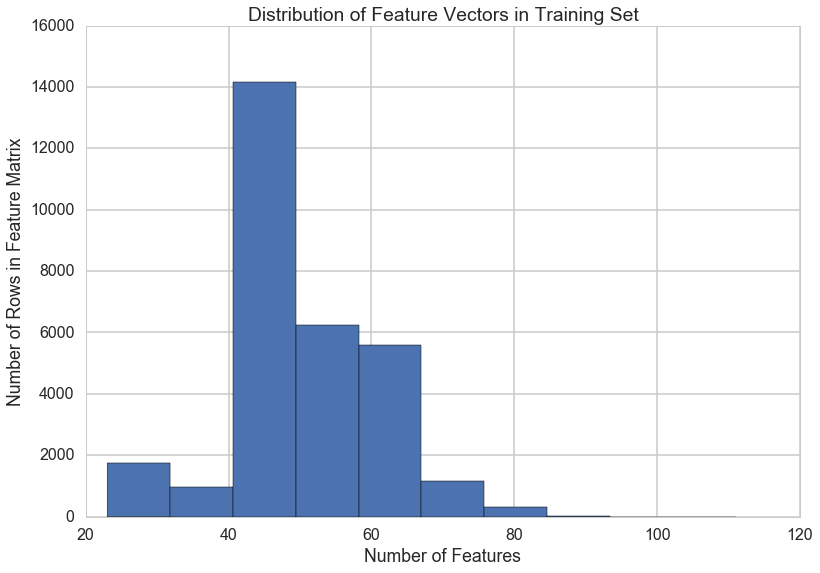

In [143]:
#calculate_num_features returns a list that contains all the number of features in each row of result_2
dist_num_features = np.array(calculate_num_features(distDict))
plt.hist(dist_num_features)
plt.title('Distribution of Feature Vectors in Training Set')
plt.xlabel('Number of Features')
plt.ylabel('Number of Rows in Feature Matrix')
plt.show()

In [144]:
dist_num_features_df = pd.DataFrame(dist_num_features)
dist_num_features_df.head()

,0
0,41
1,41
2,41
3,41
4,36


In [145]:
dist_num_features_df.drop_duplicates().size

69

**Let's find the actual feature sets**

In [146]:
feature_sets = return_feature_sets(distDict)
dir_to_store = os.getcwd()
feature_sets_df = pd.DataFrame(feature_sets)
feature_sets_df.columns = ['features', 'num_rows', 'num_features']
feature_sets_df.to_csv(path_or_buf = dir_to_store + '\\' + 'feature_sets' + '.csv')

**Feature sets with no bracket pricing**

In [147]:
no_bracket_pricing_df = result_2[result_2.bracket_pricing == 'No']
no_bracket_distDict = create_dist_dict(no_bracket_pricing_df)
no_bracket_feature_sets = return_feature_sets(no_bracket_distDict)
no_bracket_feature_sets_df = pd.DataFrame(no_bracket_feature_sets)
no_bracket_feature_sets_df.columns = ['features', 'num_rows', 'num_features']
no_bracket_feature_sets_df.to_csv(path_or_buf = dir_to_store + '\\' + 'no_bracket_feature_sets' + '.csv')

**What is the sparsity of our feature space?**

In [148]:
sparsity = compute_sparsity(result_2)
print str(round(sparsity, 1)) + '% sparse'

95.7% sparse


**Does the test set also have the same feature sets as the training set?**

In [149]:
result_test = test_set_df.merge(tube_df, how = 'left', on = 'tube_assembly_id')
result_1_test = result_test.merge(bill_of_materials_df, how = 'left', on = 'tube_assembly_id')
result_2_test = result_1_test.merge(specs_df, how = 'left', on = 'tube_assembly_id')

In [150]:
result_2_test.head()

,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,material_id,diameter,wall,...,spec1,spec2,spec3,spec4,spec5,spec6,spec7,spec8,spec9,spec10
0,TA-00001,S-0066,2013-06-23,0,0,Yes,1,SP-0035,12.7,1.65,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TA-00001,S-0066,2013-06-23,0,0,Yes,2,SP-0035,12.7,1.65,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TA-00001,S-0066,2013-06-23,0,0,Yes,5,SP-0035,12.7,1.65,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TA-00001,S-0066,2013-06-23,0,0,Yes,10,SP-0035,12.7,1.65,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TA-00001,S-0066,2013-06-23,0,0,Yes,25,SP-0035,12.7,1.65,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [151]:
#creates a dictionary that holds the different feature sets, the number of features and number of occurrences
distDict_test = create_dist_dict(result_2_test)
print len(distDict_test.keys())

810


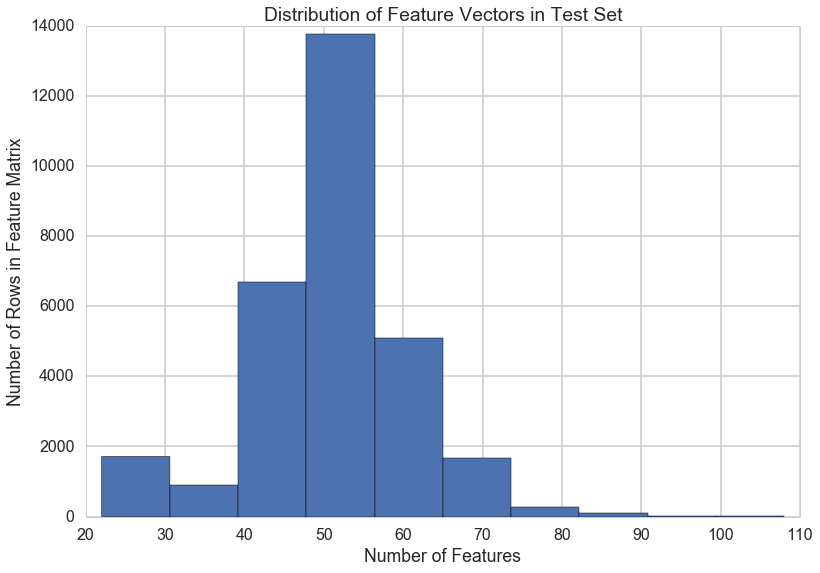

In [152]:
#calculate_num_features returns a list that contains all the number of features in each row of result_2_test
dist_num_features_test = np.array(calculate_num_features(distDict_test))
plt.hist(dist_num_features_test)
plt.title('Distribution of Feature Vectors in Test Set')
plt.xlabel('Number of Features')
plt.ylabel('Number of Rows in Feature Matrix')
plt.show()

In [153]:
dist_num_features_test_df = pd.DataFrame(dist_num_features_test)
dist_num_features_df.drop_duplicates().size

69

In [154]:
feature_sets_test = return_feature_sets(distDict_test)
dir_to_store = os.getcwd()
feature_sets_test_df = pd.DataFrame(feature_sets_test)
feature_sets_test_df.columns = ['features', 'num_rows', 'num_features']
feature_sets_test_df.to_csv(path_or_buf = dir_to_store + '\\' + 'feature_sets_test' + '.csv')

**Are there any feature sets that do not overlap between the training set and the test set?**

In [155]:
#adjust feature sets from training set (remove cost column since this is the feature we are trying to predict and won't be in
#the test set)
adjusted_feature_sets = []
for s in feature_sets:
    if 'cost' in s[0]:
        #first convert s[0] to a list and convert back to tuple at the end
        lst = list(s[0])
        lst.remove('cost')
        tup_to_add = tuple(lst)
        adjusted_feature_sets.append([tup_to_add, s[1], s[2]])
    else:
        #if cost wasn't in the feature set, then keep s as it is
        adjusted_feature_sets.append(s)
adjusted_feature_sets_df = pd.DataFrame(adjusted_feature_sets)
adjusted_feature_sets_df.columns = ['features', 'num_rows', 'num_features']

In [156]:
non_overlapping_feature_sets = adjusted_feature_sets_df.merge(feature_sets_test_df, how = 'outer', on = 'features', indicator = True)
non_overlapping_feature_sets.to_csv(path_or_buf = dir_to_store + '\\' + 'non_overlapping_feature_sets' + '.csv')

In [157]:
count_only_test = non_overlapping_feature_sets[non_overlapping_feature_sets._merge == 'right_only'].size
print 'Number of features in test set only:', count_only_test

Number of features in test set only: 2088


In [158]:
count_both_sets = non_overlapping_feature_sets[non_overlapping_feature_sets._merge == 'both'].size
print 'Number of feature sets in both:', count_both_sets

Number of feature sets in both: 2772


# Attempt Linear Regression on result_2

In [159]:
from sklearn.linear_model import LinearRegression

use **all features** in *result_2* to predict *cost* of the tube assemblies in the training set

In [160]:
X = result_2.drop('cost', axis = 1)

In [161]:
#create a linear regression object
lm = LinearRegression(normalize = True, copy_X = True)

In [162]:
#fit linear model
#lm.fit(X, result_2.cost)